# **<font color='Green'>Early Student Failure Detection in Online Learning</font>**




*A growing platform for learning has been "personal learning". One of the key feature of this platform is online learning where students use video modules and online materials to supplement classroom style learning techniques. With the rich data associated with online learning, this project seeks to undertake two important goals*

*1) Detect students who are at risk for failure as early as possible*
*2) Provide intervention to support these students and prevent adverse outcomes*

# Data Cleaning

*Using data from Open University on student online activity, assessement scores, and final outcome through the course of a semester, I analyze how early we can detect students who will fail the course*

*Important features of the data include daily number of clicks in a forum with a teacher or TA, how often students use online resources like recorded lectures, and student chat groups, practice quiz scores, and test scores*

#### <font color='Red'>Import Packages</font>


In [1]:
import pandas as pd
import collections
import random
import scipy as sp
import numpy as np
import collections
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import copy
pd.options.mode.chained_assignment = None  # default='warn'

Import Data

In [2]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentass = pd.read_csv('studentAssessment.csv')
studentinfo = pd.read_csv('studentinfo.csv')
studentreg = pd.read_csv('studentRegistration.csv')
studentvle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

Data comes in 7 different files. I merge data to do preliminary analyses

In [3]:
dset = pd.merge(assessments, studentass, how = 'inner', on = 'id_assessment')
dset =pd.merge(dset, studentinfo, how = 'inner', on = ['code_module', 'code_presentation', 'id_student'])
dset = pd.merge(dset, courses, how ='inner', on =['code_module', 'code_presentation'])
dset = pd.merge(dset, studentreg, how = 'inner', on = ['code_module', 'code_presentation', 'id_student'])
ass_nofinal = assessments.loc[assessments.assessment_type != 'Exam']

Modules are equivalent to courses. I only examine FFF (lets call it math for simplicity) because courses vary in terms of length of course, weight of examns, number of exams, timing of exams, etc. So I focus just on math for now



In [4]:
vle_fff= vle.loc[vle.code_module == 'FFF']
studentvle_fff = studentvle.loc[studentvle.code_module == 'FFF']
vle_final_fff = pd.merge(vle_fff, studentvle_fff, how = 'inner', on = ['code_module', 'code_presentation', 'id_site'])

In [5]:
dset_fff= dset.loc[dset.code_module == 'FFF']


Math is taught several times throughout the year, and because dates of courses can vary due to breaks, holidays, etct, I interpolate all the dates so that they represent the same period of time in the course

In [6]:
dset_fff.loc[:,'date1'] = list(map(lambda x,y,z: 19 if (x in [24,19] and y =='TMA') else 52 if (x in [47,52] and y =='TMA') else 87 if (x in [89, 87,94,96] and y =='TMA') else 129 if (x in [131,129, 136] and y =='TMA') else 166 if (x in [171,166, 173, 199] and y == 'TMA') else z, dset_fff.loc[:,'date'][:], dset_fff.loc[:,'assessment_type'][:], dset_fff.loc[:,'date_submitted'][:]))         
dset_fff.loc[:,'date2'] = list(map(lambda x,y,z: x*(19/24) if (x <=24 and y != 'TMA' and z in ['2014J', '2014B'] ) else x*(47/52) if (x<=52 and y != 'TMA' and z in ['2014J', '2014B']) else (87/96)*x if (x<=96 and y !='TMA' and z =='2013J') else (87/94)*x if (x<=94 and y !='TMA' and z =='2014J') else (87/89)*x if (x<=89 and y !='TMA' and z =='2013B')
 else x *(129/131) if (x<=131 and y != 'TMA' and z in ['2013J', '2013B']) else x * (129/136) if (x<136 and y!= 'TMA' and z =='2014J') else x*(166/173) if (x<=173 and y != 'TMA' and z =='2013J') else x*(166/199) if (x<=131 and y != 'TMA' and z == '2014J') else x*(166/171) if
  (x<=131 and y != 'TMA' and z =='2014B') else x*(240/241) if (x > 171 and z =='2014B') else x*(240/268) if (x > 173 and z =='2013J') else x*(240/269) if (x > 199 and z =='2014J') else x, dset_fff.loc[:,'date1'][:], dset_fff.loc[:,'assessment_type'][:], dset_fff.loc[:,'code_presentation'][:]))
#dset_fff=dset_fff.loc[dset_fff.date2 <=240]

Given the dates of when students use online materials and take assessmenets, I combine them into weeks. I.E. weekly online interaction, weekly average assessment score, etc.

In [7]:
#group dates into weeks
start =0
x= 1
dset_fff['cat'] = 'group 0'
#group = None
for i in range(7,236,7):
    end = i+1
    group = 'group ' + str(x)
    dset_fff['cat'] = list(map(lambda z,q: group if start < z < end else q, dset_fff['date2'], dset_fff['cat']))
    start = start + 7
    x= x+1
#summarise data by weeks
colFun = {'id_assessment': ['count'],
          'weight': ['mean'],
          'score': ['mean']}
grouped_dset= dset_fff.groupby(['id_student', 'code_presentation', 'cat','assessment_type'], as_index = False).agg(colFun)
grouped_dset.columns = ['id_student','code_presentation', 'group','assessment_type','num_assessment','weight','score']
#reshape data and convert na to zeros
grouped_dset= grouped_dset.pivot_table(values = ['num_assessment','weight','score'], index = ['id_student', 'code_presentation'], columns = ['assessment_type', 'group'])
grouped_dset= grouped_dset.reset_index()
grouped_dset = grouped_dset.fillna(0)
#change column names
names = list(grouped_dset.columns)
names = list(map(lambda x: ' '.join(x), names))
names = list(map(lambda x: x.strip(), names))
grouped_dset.columns = names
grouped_dset= grouped_dset.loc[:, (grouped_dset != 0).any(axis=0)]
#isolate demographic data from non VLE dataset
data = dset_fff[[ 'code_presentation','id_student','gender','highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability','final_result']]
data = data.drop_duplicates(['code_presentation', 'id_student'])
#merge data
data1 = pd.merge(data, grouped_dset, how = 'inner', on = ['id_student', 'code_presentation'])

Online activity is split it many different categories. I combine them into more meaningful ones. Namely 1) conent- when students interact with content like lectures 2) resources - when student use glossaries, practice quizes, and wiki resources 3) forum - when student use chatrooms for discussing materials 4) overall activity- accessing the homepage and other online interfaces

In [8]:
vle_final_fff['activity'] = ['content' if x in ['oucontent'] else 'resource' if x in ['resource', 'dataplus', 'glossary', 'ouelluminate', 'ouwiki', 'quiz'] else 'forum' if x in ['forumng', 'oucollaborate'] else 'activity' if x in ['homepage', 'page', 'subpage'] else 'NA' for x in vle_final_fff['activity_type']]
vle_final_fff = vle_final_fff.loc[vle_final_fff.activity != 'NA']
#reshape long to wide
efa_vle = vle_final_fff.pivot_table(values = 'sum_click', index = ['code_presentation', 'id_student', 'date'], columns ='activity', aggfunc='sum')
efa_vle = efa_vle.fillna(0)
efa_vle = efa_vle.reset_index()
#interpolate dates
efa_vle['date2'] = list(map(lambda x,z: x*(19/24) if (x <=24  and z in ['2014J', '2014B'] ) else x*(47/52) if (x<=52  and z in ['2014J', '2014B']) else (87/96)*x if (x<=96 and  z =='2013J') else (87/94)*x if (x<=94 and  z =='2014J') else (87/89)*x if (x<=89 and  z =='2013B')
 else x *(129/131) if (x<=131  and z in ['2013J', '2013B']) else x * (129/136) if (x<136 and  z =='2014J') else x*(166/173) if (x<=173  and z =='2013J') else x*(166/199) if (x<=131  and z == '2014J') else x*(166/171) if
  (x<=131  and z =='2014B') else x*(240/241) if (x > 171 and z =='2014B') else x*(240/268) if (x > 173 and z =='2013J') else x*(240/269) if (x > 199 and z =='2014J') else x, efa_vle['date'], efa_vle['code_presentation']))
efa_vle=efa_vle.loc[efa_vle.date2 <=240]
#group by week
start =0
x= 1
efa_vle['cat'] = 'group 0'
#group = None
for i in range(7,247,7):
    end = i+1
    group = 'group ' + str(x)
    efa_vle['cat'] = list(map(lambda z,q: group if start < z < end else q, efa_vle['date2'], efa_vle['cat']))
    start = start + 7
    x= x+1
grouped_vle= efa_vle.groupby(['id_student', 'code_presentation', 'cat'], as_index = False).sum()
#reshape long to wide
grouped_vle= grouped_vle.pivot_table(values = ['activity','content','forum', 'resource'], index = ['id_student', 'code_presentation'], columns = 'cat')
### convert NA to zero and rename columns
grouped_vle= grouped_vle.reset_index()
grouped_vle = grouped_vle.fillna(0)
names = list(grouped_vle.columns)
names = list(map(lambda x: ' '.join(x), names))
names = list(map(lambda x: x.strip(), names))
names
grouped_vle.columns = names



Create final dataset

In [9]:
final_dset = pd.merge(grouped_vle, data1, how = 'inner', on = ['id_student', 'code_presentation'])
final_dset.to_csv('sem.csv')

# Analysis

Target Variable: Pass or Fail

In [10]:
final_dset['pass'] = ['pass' if x in ['Distinction', 'Pass'] else 'fail' for x in final_dset['final_result']]
Y_pass= final_dset['pass']

Bar Chart of distribution of students who failed and passed

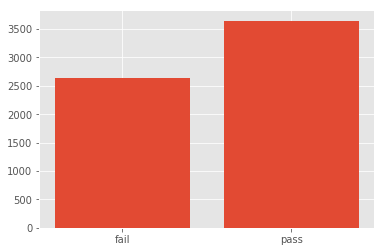

In [11]:
x_axis = ['pass', 'fail']
y_pos = [sum(Y_pass== 'pass'), sum(Y_pass =='fail')]
plt.bar(x_axis, y_pos)
plt.show()

Predictor Variables

In [12]:
predictors = [x for x in final_dset.columns if x not in ['pass', 'final_result', 'id_student','num_of_prev_attempts','code_presentation', 'code','region']]
x = final_dset[predictors]
x['imd_band'] = [0 if x == '0-10%' else 1 if x=='10-20'else 2 if x== '20-30%'else 3 if  x =='30-40%' else 4 if x== '40-50%'else 5 if  x=='50-60%'else 6 if x== '60-70%'else 7 if x== '70-80%' else 8 if x== '80-90%'else 9 if x == '90-100%' else 3 for x in x['imd_band'].copy()]
#create dummy variables
x = pd.get_dummies(x, drop_first = True)

## Random Forest full model

In [13]:
rf_full=RandomForestClassifier(n_estimators=500)

In [14]:
X_train_full, X_test_full, y_p_train_full, y_p_test_full = train_test_split(x, Y_pass, test_size=0.2)

In [15]:
model_p_full = rf_full.fit(X_train_full, y_p_train_full)
print ('Score:', model_p_full.score(X_test_full, y_p_test_full))

Score: 0.91653418124


*The full model with all of the students assessment scores, weekly virtual interaction scores, etc. Is fairly robust at predicting student failure. But this prediction is made with all data available. Or over 30 weeks of data. Can student success of failure be predicted earlier?*

## Model with only demographic data

this is data of only student demographic data. So the model does not use any course information

In [16]:
lst = x.columns.tolist()
predictors0 = [x for x in lst if re.search('[0-9]', x)==None]
x0 = x[predictors0]
rf0=RandomForestClassifier(n_estimators = 500)
X_train, X_test, y_train, y_test = train_test_split(x0, Y_pass, test_size=0.2)
model_null = rf0.fit(X_train,y_train)
print ('Score:', model_null.score(X_test, y_test))

Score: 0.614467408585


now with only demographic data, the model can predict success of failure with about 60% accuracy

## Model with demographics and first week of data

In [17]:
predictors1 = [x for x in lst if re.search('group 19$', x)]
predictors1 = predictors0 + predictors1
x1 = x[predictors0]
rf1=RandomForestClassifier(n_estimators = 500)
X_train, X_test, y_train, y_test = train_test_split(x1, Y_pass, test_size=0.2)
model_1 = rf1.fit(X_train,y_train)
print ('Score:', model_1.score(X_test, y_test))

Score: 0.60413354531


slight improvement in model prediction accuracy

## Weekly Model improvement

In [18]:
df = {'model': 0, 'classification': [model_1.score(X_test, y_test)]}
df = pd.DataFrame(df)
predictor_x= [x for x in lst if re.search('[0-9]', x)==None]
test = []
for i in range(0,36):
    predictor = [x for x in lst if re.search('group ' + str(i) +'$', x)]
    predictor_x = predictor_x + predictor
    test = x[predictor_x]
    #print(test.columns)
    rf=RandomForestClassifier(n_estimators = 500)
    #rf = GradientBoostingClassifier()
    X_train, X_test, y_train, y_test = train_test_split(test, Y_pass, test_size=0.2)
    model_1 = rf.fit(X_train, y_train)
    df= df.append({'model': i+1, 'classification': model_1.score(X_test, y_test)},ignore_index=True )
    #print(df)
    print ('week' + str(i) + ' Score:', model_1.score(X_test, y_test))


week0 Score: 0.611287758347
week1 Score: 0.644674085851
week2 Score: 0.694753577107
week3 Score: 0.682034976153
week4 Score: 0.697138314785
week5 Score: 0.725755166932
week6 Score: 0.732909379968
week7 Score: 0.717806041335
week8 Score: 0.758346581876
week9 Score: 0.767885532591
week10 Score: 0.767090620032
week11 Score: 0.775039745628
week12 Score: 0.79173290938
week13 Score: 0.85453100159
week14 Score: 0.868839427663
week15 Score: 0.85453100159
week16 Score: 0.859300476948
week17 Score: 0.864864864865
week18 Score: 0.856120826709
week19 Score: 0.903020667727
week20 Score: 0.894276629571
week21 Score: 0.883147853736
week22 Score: 0.902225755167
week23 Score: 0.89507154213
week24 Score: 0.914149443561
week25 Score: 0.904610492846
week26 Score: 0.904610492846
week27 Score: 0.924483306836
week28 Score: 0.919713831479
week29 Score: 0.922893481717
week30 Score: 0.928457869634
week31 Score: 0.935612082671
week32 Score: 0.928457869634
week33 Score: 0.926073131955
week34 Score: 0.945151033386

Steady increase in model prediction accuracy with every additional week of data. However, we see jumps at certain weeks. This coincides with weeks where student had tests

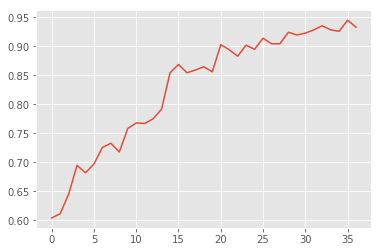

In [19]:
plt.plot(df['model'], df['classification'])
plt.show()

by week 8, the model could predict with 75% accuracy student failure. Over 85% accuracy by week 13. And after week 24, there seems to be marginal gains, suggesting that additional student information does not add to model predictive power

## Feature importance

The model can predict with confidence student success and failure, but what features does the model identify as important for its prediction? 

In [20]:
feature_imp = pd.DataFrame(sorted(list(zip(test.columns, model_1.feature_importances_)), key = lambda x: x[1], reverse=True)[0:20])
feature_imp

,0,1
0,score TMA group 24,0.070952
1,score TMA group 19,0.059748
2,weight TMA group 24,0.059539
3,num_assessment TMA group 24,0.048286
4,activity group 31,0.046408
5,score TMA group 13,0.034873
6,activity group 30,0.032986
7,weight TMA group 19,0.032826
8,num_assessment TMA group 19,0.031367
9,activity group 29,0.030231


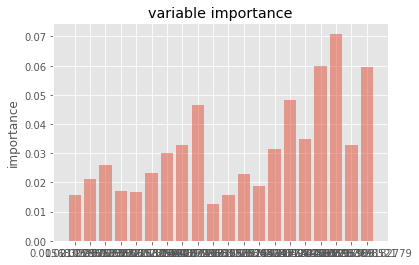

In [21]:
plt.bar(feature_imp[0], feature_imp[1], align='center', alpha=0.5)
plt.xticks(feature_imp[0], feature_imp[1])
plt.ylabel('importance')
plt.title('variable importance')
plt.show()

As expected, the strongest indicators of success and failure were tests (TMA), especially the tests taken towards the end of the course. Important online interactions mainly centered on overall activity and content activity. 

# Conclusion

As online learning continues to grow as a platform to educate students, it is important to consider how we can use the data associated with these programs to best identify students who are at risk for failure.

I use random forests to see how early student failure can be predicted. The models showed that with demographic information alone, student failure can be predicted with 60% accuracy. As weekly information on student online interactions and assessments are added, predictions for students at risk for failure greatly increase. By week 8, the model improves to 75% accurcacy, and has over 85% accuracy by week 13.

As educators continue to seek ways to identify students at risk for failure, this model provides a robust way to do so. However, it is not enough to find students at risk for failure. Intervention needs to be implemented to best understand how to improve the outcomes of these students. For analysis on best intervention techniques for students at risk for failure, please see the next project!